In [1]:
import pandas as pd

# Data Exploration

__Convert the data to a pandas dataframe for easier processing first__

In [2]:
data = open("EN/train",'r').read().split("\n\n")

In [3]:
df = pd.DataFrame([sub.split("\n") for sub in data])


In [4]:
labelled_data = []

labelled_tweet_count = 0
for labelled_tweet in data:    
    labelled_pairs = labelled_tweet.split("\n")
    for pair in labelled_pairs:
        try:
            word, tag = pair.split(" ")
            labelled_data.append((labelled_tweet_count, word, tag))
            
        except:
            print(pair)
        
    labelled_tweet_count += 1
        

In [5]:
df = pd.DataFrame(labelled_data)
df.columns = ['Sentence #', 'Word', 'Tag']
df.head()

,Sentence #,Word,Tag
0,0,RT,O
1,0,@shaunproulx,O
2,0,:,O
3,0,Encore,B-INTJ
4,0,!,O


In [6]:
# Check for any null values
df.isnull().sum()

Sentence #    0
Word          0
Tag           0
dtype: int64

See how many words, tags and tweets we have

In [7]:
words = list(set(df["Word"].values))
n_words = len(words)
n_words

3651

In [8]:
tags = list(set(df["Tag"].values))
n_tags = len(tags)
n_tags

19

In [9]:
n_tweets = max(df["Sentence #"])
n_tweets

550

In [10]:
class TweetGetter(object):
    '''
    To obtain (Word, Tag) pairs in a convenient manner
    '''
    
    def __init__(self, data):
        self.counter = 1
        self.data = data
        tuple_function = lambda s:[(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                         s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(tuple_function)
        self.tweets = [s for s in self.grouped]
        
        
    def get_next(self):
        tweet = self.grouped[self.counter]
        self.counter += 1
        return tweet
        
        

In [11]:
getter = TweetGetter(df)

In [12]:
tweet = getter.get_next()
len(tweet)

14

In [13]:
tweets = getter.tweets

In [14]:
# Check how long the tweets are
import matplotlib.pyplot as plt

plt.hist([len(s) for s in tweets])
plt.show()

<Figure size 640x480 with 1 Axes>

__Need to use equal-length input sequences for Keras NN, so need to pad the sentences to a length of 40__

In [15]:
max_len = 40
word2idx = {w:i for i, w in enumerate(words)}
tag2idx = {t:i for i, t in enumerate(tags)}

In [16]:
# Map the tweets to a sequence of numbers and then pad the sequence

from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in tweets]

Using TensorFlow backend.


In [17]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_tweets-1)

In [18]:
X[1]

array([1175, 2474, 3394, 2616, 2203,  408,  613, 2293,  685, 1919, 2550,
       2231, 2832,  383,  549,  549,  549,  549,  549,  549,  549,  549,
        549,  549,  549,  549,  549,  549,  549,  549,  549,  549,  549,
        549,  549,  549,  549,  549,  549,  549], dtype=int32)

In [19]:
# Do the same for the tags
y = [[tag2idx[w[1]] for w in s] for s in tweets]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y[1]

array([ 0, 18,  1, 16,  0, 11,  1,  5,  1, 10,  1,  5,  5, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16], dtype=int32)

__Change the tags to categorical to train the NN__

In [20]:
from keras.utils import to_categorical

y = [to_categorical(i, num_classes=n_tags) for i in y]

__Train / Validation split : May not be necessary if we just gonna use the validation set provided by the profs__

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# LSTM

In [23]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import numpy as np

In [24]:
input = Input(shape=(max_len, ))
model = Embedding(input_dim=n_words, output_dim = 40, input_length=max_len)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)

In [25]:
model = Model(input, out)

In [26]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [27]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=5, validation_split=0.1, verbose=1)

Train on 445 samples, validate on 50 samples
Epoch 1/5
445/445 [==============================] - 2s 5ms/step - loss: 1.8533 - acc: 0.5719 - val_loss: 1.2265 - val_acc: 0.6075
Epoch 2/5
445/445 [==============================] - 1s 1ms/step - loss: 1.1417 - acc: 0.6230 - val_loss: 1.1437 - val_acc: 0.6075
Epoch 3/5
445/445 [==============================] - 1s 1ms/step - loss: 1.0680 - acc: 0.6325 - val_loss: 1.1131 - val_acc: 0.6255
Epoch 4/5
445/445 [==============================] - 1s 1ms/step - loss: 1.0413 - acc: 0.6428 - val_loss: 1.0918 - val_acc: 0.6320
Epoch 5/5
445/445 [==============================] - 1s 1ms/step - loss: 1.0056 - acc: 0.6492 - val_loss: 1.0912 - val_acc: 0.6145


In [28]:
hist = pd.DataFrame(history.history)

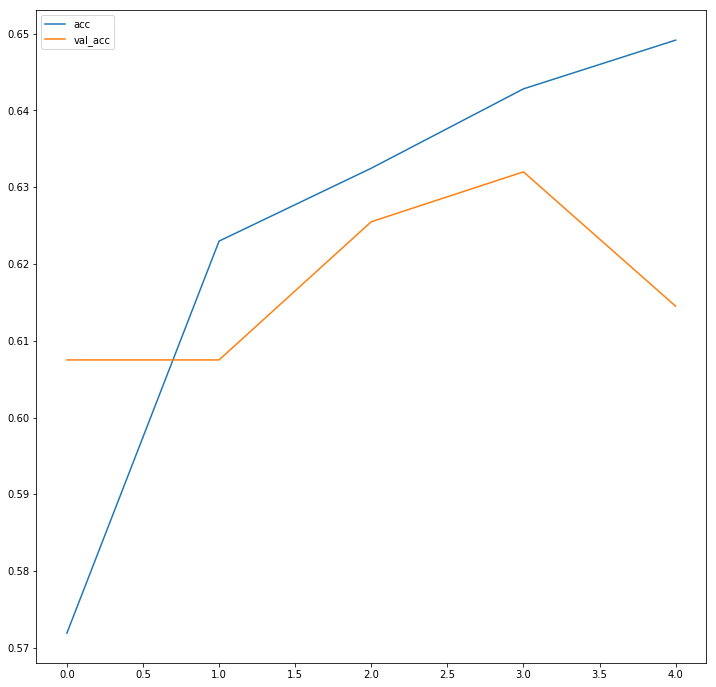

In [29]:
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.legend()
plt.show()

In [37]:
#Run on test set

score, acc = model.evaluate(X_test, np.array(y_test))
print(score, acc)

56/56 [==============================] - 0s 363us/step
0.9954815592084613 0.6553571479661124


[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0